# KNN - multiclass

In [1]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from scipy.interpolate import spline, BSpline
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import pickle
import math

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   

In [2]:
full = pd.read_csv('data/full/1000_new_train.csv')

In [3]:
full.columns

Index(['NSFW_words_score', 'news_spreaders_words_score',
       'spam_bots_words_score', 'fake_followers_words_score', 'user_id',
       'avg_fav', 'avg_hash', 'avg_len', 'avg_ret', 'default_profile',
       'favourites_count', 'followers_count', 'freq', 'friends_count',
       'listed_count', 'max_fav', 'max_hash', 'max_len', 'max_ret',
       'media_perc', 'min_hash', 'min_len', 'min_ret', 'nsfw_avg',
       'nsfw_profile', 'profile_use_background_image', 'quote_perc',
       'ret_perc', 'statuses_count', 'target', 'tweet_intradistance', 'url',
       'url_perc', 'description_len', 'name_len', 'screen_name_len', 'age',
       'url_entropy', 'min_fav'],
      dtype='object')

In [4]:
X = full.drop(columns=["user_id", "target"])
y = full['target']

## Functions

In [5]:
def grid_search(X, y, params):
    
    results = []
    for x, f in zip(X,['standard', 'weighted', 'normalized']):
        grid = GridSearchCV(KNeighborsClassifier(), params, cv=10, scoring='f1_macro')
        grid.fit(x, y)
        d1 = {'dataset': f}
        d2 = dict(list(grid.cv_results_.items()) + list(d1.items()))
        results.append(d2)
        print(f + ' done')

    return results

In [6]:
def info_gain(distances):
    #print(distances)
    weights = np.exp(-distances)**2 / 2
    #print(weights)
    return weights

In [7]:
def gaussian_kernel(distances):
    #print(distances)
    weights = np.exp(-distances)**2 / 2
    #print(weights)
    return weights

In [8]:
def evaluate(X, y, k=10, weights='uniform'):
    knn = KNeighborsClassifier(n_neighbors=k, weights=weights)
    scoring = ['f1_macro', 'precision_macro', 'recall_macro'] 
    scores = []
    cv = cross_validate(knn, X, y, cv=10, scoring=scoring)
    scores.append(cv['test_precision_macro'].mean())
    scores.append(cv['test_recall_macro'].mean())
    scores.append(cv['test_f1_macro'].mean())
    return scores

In [9]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, title, filename):
    # Get Test Scores Mean and std for each grid search
    
    cv_results.reset_index(drop=True, inplace=True)
    std = cv_results.loc[cv_results.dataset == 'standard'].reset_index(drop=True)
    w = cv_results.loc[cv_results.dataset == 'weighted'].reset_index(drop=True)
    
    std_scores_mean = std['mean_test_score']
    std_scores_mean = np.array(std_scores_mean).reshape(len(grid_param_2),len(grid_param_1))
    
    w_scores_mean = w['mean_test_score']
    w_scores_mean = np.array(w_scores_mean).reshape(len(grid_param_2),len(grid_param_1))
    
    
    
    xnew = np.linspace(grid_param_1[0], grid_param_1[-1], 10)

    # Plot Grid search scores
    fig, ax = plt.subplots(1,1, figsize=(16,12))
    

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    color = ['blue', 'g', 'r', 'y']
    i = 0
    for idx, val in enumerate(grid_param_2):
        c = color[i]
        i += 1
        
        std_smooth = spline(grid_param_1, std_scores_mean[idx,:], xnew)
        w_smooth = spline(grid_param_1, w_scores_mean[idx,:], xnew)
        
        ax.plot(grid_param_1, std_scores_mean[idx,:], '-', label= name_param_2 + '(std): ' + str(val), linewidth=4,)
        ax.plot(grid_param_1, w_scores_mean[idx,:], ':', label= name_param_2 + '(wgh): ' + str(val), linewidth=4,)
    
    
    
    best_index = std['mean_test_score'].values.argmax()
    best_1_param = std.loc[best_index]['param_n_neighbors']
    best_2_param = std.loc[best_index]['param_p']
    best_score = std['mean_test_score'].max()
    min_score = std['mean_test_score'].min()
    plt.axvline(x=best_1_param, linestyle=':', color='grey', linewidth=2)
    
    # Plot a dotted vertical line at the best score for that scorer marked by x
    plt.plot([best_1_param,], [best_score],
           linestyle=':', color='black', marker="x", markeredgewidth=3,markersize=26, ms=8)
    
    plt.annotate("%0.3f (k = %d, p = %d, non-weighted features)" % (best_score, best_1_param, best_2_param),
                    (best_1_param+1, best_score-0.002), fontsize=24)
    
    best_index = w['mean_test_score'].values.argmax()
    best_1_param = w.loc[best_index]['param_n_neighbors']
    best_2_param = w.loc[best_index]['param_p']
    best_score = w['mean_test_score'].max()
    min_score = w['mean_test_score'].min()
    plt.axvline(x=best_1_param, linestyle=':', color='grey', linewidth=2)
    
    # Plot a dotted vertical line at the best score for that scorer marked by x
    plt.plot([best_1_param,], [best_score],
           linestyle=':', color='black', marker="x", markeredgewidth=3,markersize=26, ms=8)
    
    plt.annotate("%0.3f (k = %d, p = %d, weighted features)" % (best_score, best_1_param, best_2_param),
                    (best_1_param+1, best_score), fontsize=24)
    

    ax.tick_params(labelsize=20)
    ax.set_title(title, fontsize=30)
    ax.set_xlabel(name_param_1, fontsize=28)
    ax.set_ylabel('F1 Macro Score', fontsize=28)
    ax.legend(loc="lower right", fontsize=22)
    ax.grid('on')
    fig.savefig('data/full/'+ filename +'.png')

In [10]:
def grid_eval(X, y, params):
    
    grid = GridSearchCV(KNeighborsClassifier(), params, cv=10, scoring='f1_macro')
    grid.fit(X, y)
    
    return pd.DataFrame(grid.cv_results_)

### User features

In [11]:
# only our user features
X = X[['default_profile', 'favourites_count', 'followers_count', 'friends_count', 'listed_count','profile_use_background_image',
       'statuses_count', 'url', 'description_len', 'name_len', 'screen_name_len', 'age']]

## Uniform kernel

In [11]:
user_score = evaluate(X, y, 6)
print('Precision:')
print(user_score[0])
print('Recall:')
print(user_score[1])
print('F1:')
print(user_score[2])

Precision:
0.9154761417252395
Recall:
0.9080767736980434
F1:
0.9063007937694707


## Gaussian kernel

In [12]:
model = RandomForestClassifier(n_estimators = 400, max_depth = 28, criterion = 'entropy')

In [13]:
model.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=28, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
importances = model.feature_importances_

In [15]:
X_ig = X * importances

In [16]:
scaler = MinMaxScaler()
X_n = scaler.fit_transform(X)

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [17]:
knn = KNeighborsClassifier(n_neighbors=5, weights=gaussian_kernel)

In [78]:
knn.fit(X_n,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights=<function gaussian_kernel at 0x1a14e90840>)

In [18]:
user_score = evaluate(X_n, y, 20, gaussian_kernel)
print('Precision:')
print(user_score[0])
print('Recall:')
print(user_score[1])
print('F1:')
print(user_score[2])

Precision:
0.778629793656276
Recall:
0.6966846413984247
F1:
0.6913277580091793


In [19]:
user_score = evaluate(X, y, 5)
print('Precision:')
print(user_score[0])
print('Recall:')
print(user_score[1])
print('F1:')
print(user_score[2])

Precision:
0.9129992220732793
Recall:
0.9069461029086735
F1:
0.9045937371726784


In [20]:
user_score = evaluate(X_ig, y, 5)
print('Precision:')
print(user_score[0])
print('Recall:')
print(user_score[1])
print('F1:')
print(user_score[2])

Precision:
0.9200347539727192
Recall:
0.9127216652240877
F1:
0.9113441058374286


## Grid Search

In [26]:
params = {'n_neighbors': [1,2,3,5,10,15,20,25], 'p':[1, 2, 3, 4]}

In [27]:
X_list = [X, X_ig, X_n]
n_neighbors = [1,2,3,5,10,15,20,25]
p = [1, 2, 3, 4]

In [28]:
results = grid_search(X_list, y, params)

standard done
weighted done
normalized done


In [44]:
res = pd.DataFrame()
for elem in results[:2]:
    res=res.append(pd.DataFrame(elem), ignore_index=True)

In [46]:
res = res.sort_values(by=['param_p','param_n_neighbors'])

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one

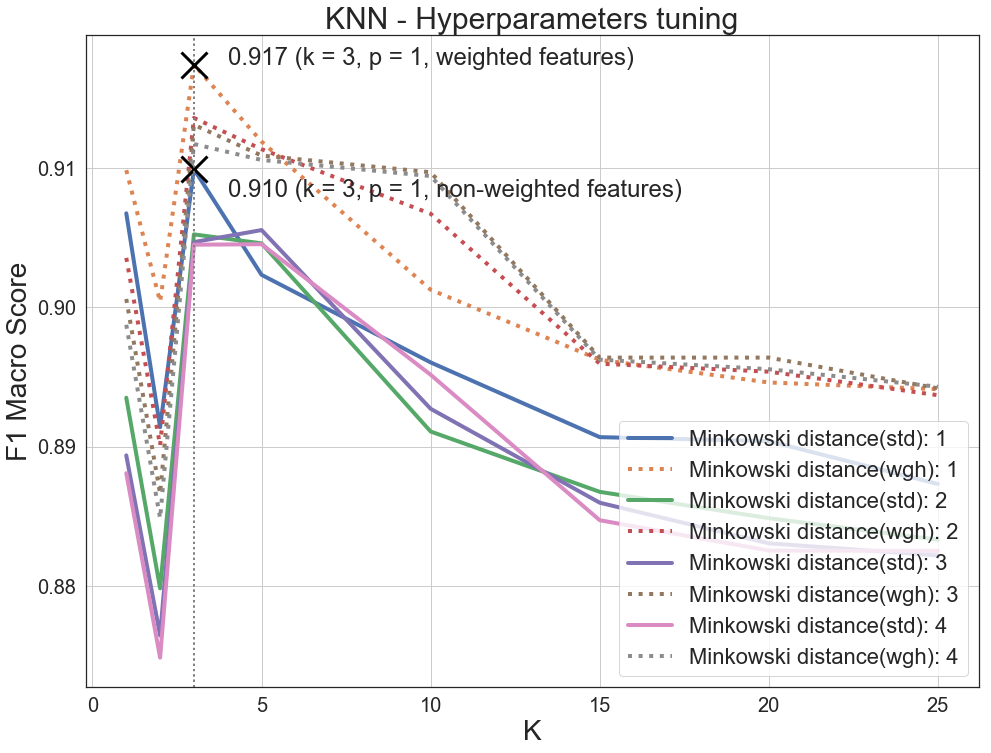

In [58]:
plot_grid_search(res, n_neighbors, p, 'K', 'Minkowski distance', 'KNN - Hyperparameters tuning', 'knn_tuning')

In [66]:
X_ig

,default_profile,favourites_count,followers_count,friends_count,listed_count,profile_use_background_image,statuses_count,url,description_len,name_len,screen_name_len,age
0,0.000000,33220.070924,133690.082673,882.381246,426.994639,0.002117,7192.134218,0.047712,5.658412,0.124957,0.076459,0.661253
1,0.000000,19737.686325,1044.552002,352.731548,8.326036,0.002117,32105.022142,0.047712,5.767227,0.199931,0.067963,0.661253
2,0.000000,57.650960,27570.034787,40.954737,204.178076,0.000000,9053.092932,0.047712,0.000000,0.099966,0.067963,0.661253
3,0.000000,132.562686,40.154277,27.066425,0.507170,0.002117,84.785120,0.047712,1.450875,0.187436,0.101945,0.661253
4,0.000000,34393.803036,1357.809443,816.490677,10.270187,0.002117,19688.067140,0.000000,4.062449,0.449846,0.127431,0.661253
5,0.000000,93.898569,2.839191,20.516824,0.042264,0.002117,8.461920,0.000000,1.559690,0.224923,0.050972,0.661253
6,0.000000,12644.892215,27.039917,30.538503,0.169057,0.002117,4314.417747,0.000000,0.000000,0.149949,0.101945,0.661253
7,0.000000,2793.137211,94.639710,142.749747,0.295849,0.002117,259.498879,0.047712,0.507806,0.149949,0.093450,0.661253
8,0.000000,8684.927199,1034.682432,615.662536,4.944905,0.002117,6390.408781,0.047712,5.730955,0.212427,0.076459,0.661253
9,0.000000,84.232540,2.163193,20.359002,0.000000,0.002117,10.121120,0.000000,2.176312,0.124957,0.067963,0.661253


In [63]:
model = KNeighborsClassifier(p=1, n_neighbors=5)

In [64]:
model.fit(X_ig,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=1,
           weights='uniform')

In [65]:
pickle.dump(model, open("../scripts/knn.model", "wb"))

In [16]:
pickle.dump(importances, open("../scripts/knn.weights", "wb"))